# Extending single-head attention to multi-head attention

There will be 2 ways this will be done:
- intuitively build a multi-head attention module by stacking multiple `CausalAttention` modules
- then implement the same multi-head attention module in a more complicated but more computationally efficient way.

## 1. Stacking Multiple Single-Head Attention Layers

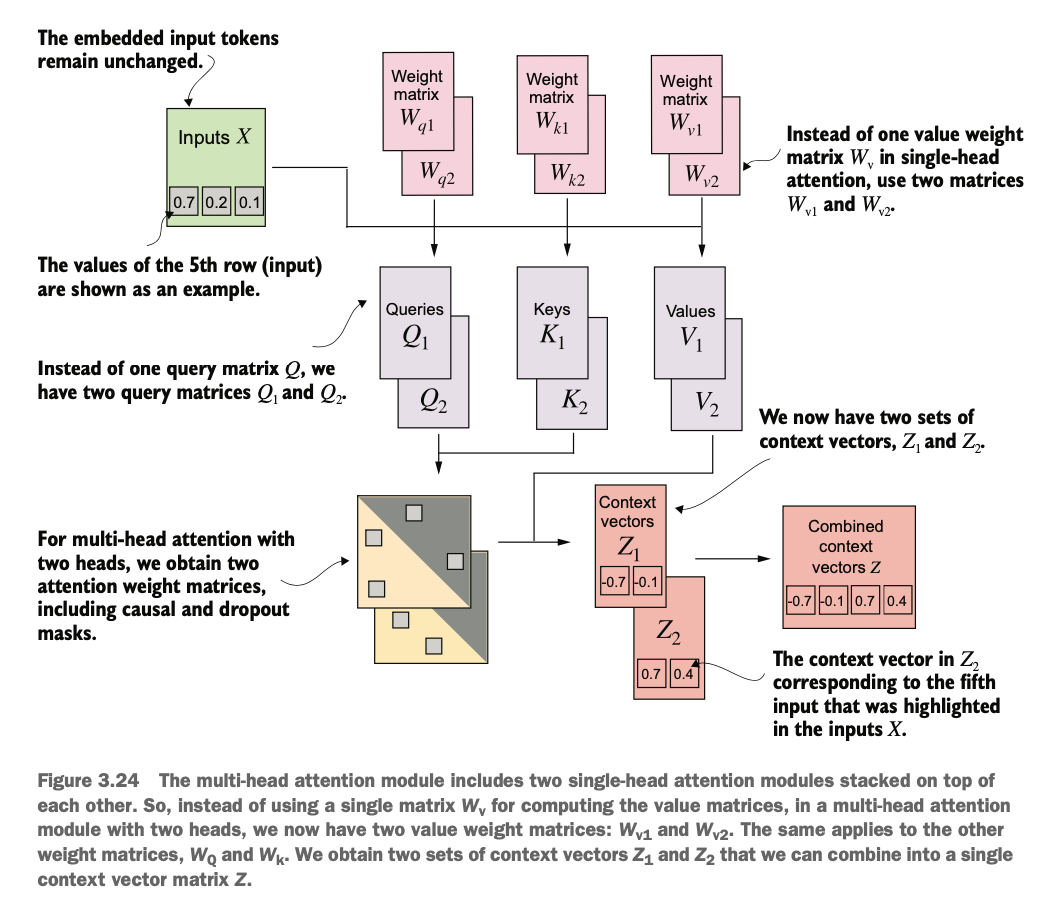

In [1]:
import torch
import torch.nn as nn
from causalattention import CausalAttention

#### A wrapper class to implement multi-head attention

torch.cat: Concatenates the given sequence of seq tensors in the given dimension. All tensors must either have the same shape (except in the concatenating dimension) or be a 1-D empty tensor with size (0,).\
documentation: https://pytorch.org/docs/stable/generated/torch.cat.html

ModuleList: Holds submodules in a list. ModuleList can be indexed like a regular Python list, but modules it contains are properly registered, and will be visible by all Module methods.\
documentation: https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html

In [2]:
class MultiHeadAttentionWrapper(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [CausalAttention(
                d_in, d_out, context_length, dropout, qkv_bias
            )
            for _ in range(num_heads)]
        )

    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)

In [3]:
torch.manual_seed(123)

inputs = torch.tensor(
    [[0.43, 0.15, 0.89],
     [0.55, 0.87, 0.66],
     [0.57, 0.85, 0.64],
     [0.22, 0.58, 0.33],
     [0.77, 0.25, 0.10],
     [0.05, 0.80, 0.55]]
)

batch = torch.stack((inputs, inputs), dim=0)
context_length = batch.shape[1] # number of tokens, this
d_in, d_out = 3, 2

In [4]:
mha = MultiHeadAttentionWrapper(
    d_in, 2, context_length, 0.0, num_heads=2
)
context_vecs = mha(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([2, 6, 4])


---

## 2. Implementing multi-head attention with weight splits

torch.Tensor.view: Returns a new tensor with the same data as the self tensor but of a different shape.

documentation: https://pytorch.org/docs/stable/generated/torch.Tensor.view.html

In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        self.out_proj = nn.Linear(d_out, d_out) # for combining the head outputs at the end with Linear layer
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        # with .view below, I'm splitting all of keys, values, & queries (which had b,
        # num_tokens, d_in. But now d_in gets reshaped to --> num_heads, head, dim)
        # Point to note here is: b * num_tokens * d_in SHOULD equal:
        # b * num_tokens * self.num_heads * self.head_dim. Otherwise torch.view doesn't work. Also
        # makes logical sense anyway because d_in is being reshaped into self.num_heads, self.head_dim.
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transposing from shape (b, num_tokens, num_heads, head_dim) to (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2, 3) # batched matmul between 3rd & 4th dimensions
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2) # shape: (b, num_tokens, n_heads, head_dim)

        # Combines heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(
            b, num_tokens, self.d_out
        )

        context_vec = self.out_proj(context_vec) # optional linear projection
        return context_vec

#### ↑ What is happening?

From the book:\
Basically, the splitting of the query, key, and value tensors is achieved through tensor reshaping and transposing operations using PyTorch’s `.view` and `.transpose` methods. The input is first transformed (via linear layers for queries, keys, and values) and then reshaped to represent multiple heads.

The key operation is to split the `d_out` dimension into `num_heads` and `head_dim`, where `head_dim = d_out / num_heads`. This splitting is then achieved using the `.view` method: a tensor of dimensions `(b, num_tokens, d_out)` is reshaped to dimension `(b, num_tokens, num_heads, head_dim)`.

The tensors are then transposed to bring the `num_heads` dimension before the `num_tokens` dimension, resulting in a shape of `(b, num_heads, num_tokens, head_dim)`. This transposition is crucial for correctly aligning the `queries`, `keys`, and `values` across the different heads and performing batched matrix multiplications efficiently.

Continuing with `MultiHeadAttention`, after computing the attention weights and context vectors, the context vectors from all heads are transposed back to the shape `(b, num_tokens, num_heads, head_dim)`. These vectors are then reshaped (flattened) into the shape `(b, num_tokens, d_out)`, effectively combining the outputs from all heads.

Additionally, an output projection layer (`self.out_proj`) has been added to `MultiHeadAttention` after combining the heads, which is not present in the `CausalAttention` class. This output projection layer is not strictly necessary, but it is commonly used in many LLM architectures.

In [6]:
torch.manual_seed(123)

inputs = torch.tensor(
    [[0.43, 0.15, 0.89],
     [0.55, 0.87, 0.66],
     [0.57, 0.85, 0.64],
     [0.22, 0.58, 0.33],
     [0.77, 0.25, 0.10],
     [0.05, 0.80, 0.55]]
)

d_out = 2
batch = torch.stack((inputs, inputs), dim=0)
print("batch shape:", batch.shape)
batch_size, context_length, d_in = batch.shape
batch

batch shape: torch.Size([2, 6, 3])


tensor([[[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]],

        [[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]]])

In [7]:
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(f'Context_vecs:\n{context_vecs}\n\nContext_vecs.shape: {context_vecs.shape}')

Context_vecs:
tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)

Context_vecs.shape: torch.Size([2, 6, 2])


---

# Exercise 3.3 Initializing GPT-2 size attention modules

Using the MultiHeadAttention class, initialize a multi-head attention module that has the same number of attention heads as the smallest GPT-2 model (12 attention heads). Also ensure that you use the respective input and output embedding sizes similar to GPT-2 (768 dimensions). Note that the smallest GPT-2 model supports a context length of 1,024 tokens.

In [8]:
from multihead import MultiHeadAttention

In [9]:
gpt2_attention = MultiHeadAttention(
    d_in=768,
    d_out=768,
    context_length=1024,
    dropout=0.1, # Standard dropout rate (adjustable)
    num_heads=12,
    qkv_bias=True
)

In [10]:
batch_size = 32
seq_length = 1024  # Can be any length up to 1024

x = torch.randn(batch_size, seq_length, 768)

In [11]:
output_context_vecs = gpt2_attention(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {output_context_vecs.shape}")
print(f"Number of attention heads: {gpt2_attention.num_heads}")
print(f"Dimension per head: {gpt2_attention.head_dim}")

print(f"\nOutput context vectors: {output_context_vecs}")

Input shape: torch.Size([32, 1024, 768])
Output shape: torch.Size([32, 1024, 768])
Number of attention heads: 12
Dimension per head: 64

Output context vectors: tensor([[[-2.2494e-01, -6.5848e-01,  4.2577e-01,  ..., -5.0112e-01,
          -2.3396e-01, -6.4555e-01],
         [-8.6491e-02, -1.9155e-01,  6.8612e-02,  ...,  2.0351e-02,
           1.2839e-01, -3.4677e-01],
         [-1.2043e-01, -5.2268e-02,  1.4475e-01,  ..., -2.2134e-01,
           2.4214e-01, -2.8281e-01],
         ...,
         [ 1.1803e-02, -8.5207e-03,  7.8421e-03,  ...,  1.3376e-02,
           6.0192e-02,  3.0261e-02],
         [ 3.2262e-03, -1.4104e-04,  1.9563e-02,  ...,  1.0004e-02,
           5.1499e-02,  8.4496e-03],
         [-1.6775e-03, -1.5348e-02,  7.8113e-03,  ...,  1.4955e-02,
           6.2812e-02,  1.7308e-02]],

        [[-7.4880e-01, -1.0809e-01,  1.2842e-01,  ..., -3.0842e-01,
           1.1797e-01,  3.6341e-01],
         [-1.1559e-01, -1.8312e-02,  3.7632e-01,  ..., -2.9730e-01,
          -8.3802e-0